<a href="https://colab.research.google.com/github/RuslanFF1968/Pioneer/blob/main/Clustering_of_cards_in_online_store.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Brief description


1. Outputting two hystograms:
 - distribution of class sizes - how many cards,
 - distribution of the amount of unique positions in the class.
2. Writing an advanced visualization function for one selected class:
 - class size,
 - amount of unique positions,
 - positions that are contained in at least 20% of the cards,
 - words in item descriptions that occur in at least 20% of items to track mono-branded and mono-commodity purchases.


In [ ]:
import pandas as pd                # Импортируем библиотеку pandas
import matplotlib.pyplot as plt    # Импортируем модуль pyplot библиотеки matplotlib для построения графиков
from tensorflow.keras import utils # Импортируем модуль utils библиотеки tensorflow.keras для получения OHE-представления
import numpy as np                 # Импортируем библиотеку numpy
from sklearn.cluster import KMeans # Импортируем библиотеку KMeans для кластеризации
import re                          # Регулярные выражения
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence,tokenizer_from_json
from sklearn.preprocessing import StandardScaler, LabelEncoder # Импортируем библиотеку StandardScaler и LabelEncoder
import time

# Статический вывод графики (графики отображаются в той ячейке, в которой используется plt.show())
%matplotlib inline

In [ ]:
# Подгружаем гугл-диск
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Подготовка базы

In [ ]:
# Загружаем базу
df = pd.read_csv('/content/drive/My Drive/Базы/online_carts.csv')
df

,Unnamed: 0,Валовая прибыль,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,NaN,Период: Февраль 2019 г. - Август 2019 г.,NaN,NaN,NaN
1,NaN,Показатели: Стоимость продажи (руб.)(С НДС),Количество(Базовых ед.),NaN,NaN
2,NaN,Группировки строк: ЗаказПокупателя.Дата оправк...,ЗаказПокупателя.ID заказа (Элементы),Номенклатура.Наименование (Элементы),NaN
3,NaN,Отборы:\nПодразделение В списке (estel.m-cosme...,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...
99627,NaN,Kapous Блеск-шампунь Brilliants gloss 250 мл,347,1,NaN
99628,NaN,Крем-бальзам-архитектор волос для восстановле...,345,1,NaN
99629,NaN,Услуга доставки DPD до двери,350,1,NaN
99630,NaN,Шампунь разглаживающий с глиоксиловой кислот...,304,1,NaN


In [ ]:
new = df.drop(['Unnamed: 0'], axis =1)                             # Удалим пустой столбец
new.insert(0, column='Дата', value = [x for x in range(len(new))]) # Вставим новую колонку "Дата", чтобы из базы вытащить временные данные в отдельную колонку
new = new.fillna('unknown')                                        # Все Nan заполним строкой "unknown", чтобы не выскакивало ошибок

In [ ]:
# Здесь будут лежать все индексы строк, где есть информация в формате даты
date_list = list(new[new['Валовая прибыль'].str.contains("\d\d.\d\d.2019")].index)

indx=0
for i in range(len(new)):                       # Проходимся по каждой строке базы
  if i in date_list:                            # Если индекс находится среди тех, где есть формат даты
    indx = i                                    # Обновляем текущий индекс
  new['Дата'][i] = new['Валовая прибыль'][indx] # Присваиваем текущий индекс всем последующим строкам, пока не наткнемся на новый индекс-дату


<>:2: SyntaxWarning: invalid escape sequence '\d'
<>:2: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipython-input-87192792.py:2: SyntaxWarning: invalid escape sequence '\d'
  date_list = list(new[new['Валовая прибыль'].str.contains("\d\d.\d\d.2019")].index)
/tmp/ipython-input-87192792.py:8: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: ht

In [ ]:
new = new.drop(new[new['Дата'].str.contains('Период')].index,axis = 0)           # Удалим строки "Период"
new = new.drop(new[new['Валовая прибыль'].str.contains('unknown')].index,axis=0) # Удалим пустые строки между корзинами
new = new.drop(new[new['Валовая прибыль']==new['Дата']].index)                   # Удалим строки-даты, которые находятся в столбце корзин
new.reset_index(inplace=True)                                                    # Обновим индекс
new = new.drop('index',axis=1)                                                   # Удалим ненужную колонку

In [ ]:
new.head()

,Дата,Валовая прибыль,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,01.01.2019 0:00:00,MCOSM13113,26236,9,unknown
1,01.01.2019 0:00:00,CONTURA (HS61) машинка для стрижки волос,9059,1,unknown
2,01.01.2019 0:00:00,Holika Holika Универсальный гель 99% алоэ вера...,539,1,unknown
3,01.01.2019 0:00:00,Kapous Бальзам-уход для придания объема Volume...,181,1,unknown
4,01.01.2019 0:00:00,Kapous Шампунь для придания объема Volume up 3...,181,1,unknown


### 1. Удалите из выборки все строки про доставку

In [ ]:
# Указываем "доставка", чтобы удалить все слова, связанные с доставкой, поставкой и т. д.
new[new['Валовая прибыль'].str.contains("доставка")]

,Дата,Валовая прибыль,Unnamed: 2,Unnamed: 3,Unnamed: 4


In [ ]:
new = new.drop(new[new['Валовая прибыль'].str.contains('оставк')].index, axis=0)
new.reset_index(inplace=True)  # Обновим индекс
new = new.drop('index',axis=1) # Удалим ненужную колонку

In [ ]:
# Посмотрим, остались ли строки, содержащие информацию про доставку
new[new['Валовая прибыль'].str.contains("оставк")]

,Дата,Валовая прибыль,Unnamed: 2,Unnamed: 3,Unnamed: 4


In [ ]:
# Удалим лишние пробелы и символы
for i,pos in enumerate(new['Валовая прибыль']):
  pos=re.sub(r"[\[\](),.«»\"\']"," ",pos) # Удалим лишние скобки, запятые, точки
  pos=pos.strip()                         # Удаляем пробелы в начале и в конце строки
  pos=pos.lower()                         # Приводим к нижнему регистру
  pos=re.sub("\s+"," ",pos)               # Удалим лишние пробелы
  pos=re.sub("(\d)\s*ml","\g<1>мл",pos)   # Заменим латиницу
  pos=re.sub("(\d)\s*l","\g<1>л",pos)     # Заменим латиницу
  pos=re.sub("(\d)\s*g","\g<1>g",pos)     # Заменим латиницу
  pos=re.sub("(\d)\s*sm","\g<1>см",pos)   # Заменим латиницу

  pos=re.sub("(\S)\s*-\s*(\S)","\g<1>-\g<2>",pos)       # Улучшим дефисы
  pos=re.sub("(\d+) (мл|г|см|м|л|мг)","\g<1>\g<2>",pos) # Подвинем единицы измерения

  new['Валовая прибыль'][i]=pos


<>:6: SyntaxWarning: invalid escape sequence '\s'
<>:7: SyntaxWarning: invalid escape sequence '\d'
<>:7: SyntaxWarning: invalid escape sequence '\g'
<>:8: SyntaxWarning: invalid escape sequence '\d'
<>:8: SyntaxWarning: invalid escape sequence '\g'
<>:9: SyntaxWarning: invalid escape sequence '\d'
<>:9: SyntaxWarning: invalid escape sequence '\g'
<>:10: SyntaxWarning: invalid escape sequence '\d'
<>:10: SyntaxWarning: invalid escape sequence '\g'
<>:12: SyntaxWarning: invalid escape sequence '\S'
<>:12: SyntaxWarning: invalid escape sequence '\g'
<>:13: SyntaxWarning: invalid escape sequence '\d'
<>:13: SyntaxWarning: invalid escape sequence '\g'
<>:6: SyntaxWarning: invalid escape sequence '\s'
<>:7: SyntaxWarning: invalid escape sequence '\d'
<>:7: SyntaxWarning: invalid escape sequence '\g'
<>:8: SyntaxWarning: invalid escape sequence '\d'
<>:8: SyntaxWarning: invalid escape sequence '\g'
<>:9: SyntaxWarning: invalid escape sequence '\d'
<>:9: SyntaxWarning: invalid escape sequence

Туториал по регулярным выражениям https://tproger.ru/translations/regular-expression-python/

### Разделение базы на корзины

In [ ]:
new[200:230]

,Дата,Валовая прибыль,Unnamed: 2,Unnamed: 3,Unnamed: 4
200,01.02.2019 0:00:00,y sf069 p пилка рисунок 240/240 зебра в инд уп...,53,1,unknown
201,01.02.2019 0:00:00,бигуди-липучки желтые d 32мм 12 шт,99,1,unknown
202,01.02.2019 0:00:00,интенсивный восстанавливающая маска 150мл wella,1109,1,unknown
203,01.02.2019 0:00:00,кондиционер для окрашенных волос color radianc...,2114,2,unknown
204,01.02.2019 0:00:00,пена для укладки экстрасильной фиксации 300мл ...,789,1,unknown
205,01.02.2019 0:00:00,пудра для обесцвечивания 30гр de luxe,180,3,unknown
206,01.02.2019 0:00:00,серебристый шампунь для светлых оттенков 1000мл,1683,3,unknown
207,01.02.2019 0:00:00,стайлер для волос dewal stilissimo2 38мм керам...,3998,2,unknown
208,01.02.2019 0:00:00,хромоэнергетический комплекс,450,1,unknown
209,01.02.2019 0:00:00,шампунь для окрашенных волос color radiance 10...,1528,2,unknown


**Выписываем индексы флагов в отдельный список**

In [ ]:
# Здесь будут лежать все индексы строк, где строка содержит флаг "MCOSM" начала корзины
cart_list = list(new[new['Валовая прибыль'].str.contains("MCOSM".lower())].index)

# Здесь будут лежать все индексы строк, где строка содержит флаг "CAFRE" начала корзины
cafre_list = list(new[new['Валовая прибыль'].str.contains("CAFRE".lower())].index)

In [ ]:
# Совместим два списка
mixed_list = sorted(cart_list+cafre_list)
print(mixed_list)

cart_list=mixed_list

[0, 8, 109, 145, 146, 150, 155, 164, 169, 173, 177, 182, 188, 189, 212, 220, 227, 230, 241, 244, 248, 254, 262, 274, 277, 278, 283, 293, 304, 324, 331, 333, 338, 344, 352, 356, 357, 361, 370, 372, 375, 377, 382, 385, 387, 393, 399, 400, 407, 418, 424, 430, 432, 444, 450, 451, 453, 457, 461, 464, 491, 499, 501, 504, 510, 513, 522, 527, 532, 533, 534, 540, 544, 549, 554, 558, 562, 571, 574, 581, 585, 586, 588, 591, 592, 596, 598, 605, 609, 613, 615, 618, 723, 731, 736, 737, 745, 747, 760, 772, 804, 806, 818, 822, 865, 870, 876, 923, 929, 940, 943, 948, 958, 963, 972, 978, 985, 990, 995, 998, 1006, 1009, 1011, 1019, 1026, 1030, 1034, 1036, 1053, 1057, 1058, 1063, 1071, 1085, 1088, 1096, 1099, 1104, 1105, 1111, 1112, 1116, 1118, 1121, 1124, 1127, 1131, 1133, 1139, 1145, 1157, 1160, 1170, 1185, 1189, 1190, 1192, 1196, 1201, 1202, 1205, 1206, 1211, 1213, 1215, 1220, 1222, 1224, 1226, 1232, 1235, 1240, 1247, 1256, 1262, 1264, 1265, 1266, 1267, 1270, 1278, 1281, 1282, 1284, 1286, 1291, 1294, 1

**Формируем корзины**

In [ ]:
carts = []                     # Здесь будут лежать все корзины
cart=[]                        # В этом списке будет текущая корзина
i=0                            # Счетчик для прохождения по базе
val = new['Валовая прибыль']   # Будем работать с этим столбцом
allPositions = []              # Создаем пустой список позиций

while i!=len(new):             # Пока не дойдем до конца списка
  if i in cart_list:           # Если счетчик в списке индексов-корзин
    if i!=cart_list[-1]:       # Проверяем, если это не последний индекс-флаг
      ind = cart_list.index(i) # Текущему индексу-флагу присваиваем значение конкретно этой корзины

      # Если корзина пустая (после удаления услуг)
      if (i==cart_list[ind+1]-1):
        i+=1

      # Пробегаемся дальше по счетчику до момента, когда он не будет равен следующему в списке индексу-флагу
      # Если условия соблюдаются, то закидываем следующую строку в текущую корзину
      # Инкремент счетчика
      while i<cart_list[ind+1]-1:
        cart.append(val[i+1])
        allPositions.append(val[i+1])
        i+=1

    else: # Если же текущий индекс-флаг последний в списке, пробегаемся дальше по счетчику
          # До момента, когда он не будет равен концу списка всех строк в столбце-1
          # Если условия соблюдаются, то закидываем следующую строку в текущую корзину
      while i<(len(new)-1):
        cart.append(val[i+1])
        allPositions.append(val[i+1])
        i+=1

    carts.append(cart)         # Закидываем корзину в список всех корзин
    cart=[]                    # Очищаем корзину

  else:
    i+=1                       # Если счетчик не в списке корзин, то инкрементируем

**Подчистим пустые корзины**

In [ ]:
# Проверим, есть ли пустые корзины
for i,cart in enumerate(carts):
  if (len(cart)==0):
    print(i,end=" ")

3 12 24 35 46 54 68 69 80 83 94 129 137 139 154 158 160 175 176 177 181 192 194 195 203 222 223 225 231 235 238 255 267 269 302 303 307 311 313 352 364 365 374 404 414 416 424 438 453 454 458 465 469 470 472 494 496 502 509 529 545 546 548 565 570 579 600 606 609 618 625 628 629 639 646 660 665 673 683 719 720 733 738 742 754 766 769 775 778 812 822 829 832 849 852 866 869 871 877 885 890 896 929 932 936 939 955 971 981 990 991 1016 1025 1039 1052 1075 1096 1127 1153 1188 1215 1221 1224 1247 1253 1260 1280 1289 1291 1303 1307 1320 1321 1336 1339 1346 1404 1420 1445 1466 1509 1513 1529 1530 1532 1547 1548 1552 1555 1561 1564 1566 1586 1589 1593 1616 1620 1623 1627 1634 1645 1648 1657 1664 1681 1695 1701 1702 1717 1737 1755 1757 1761 1772 1773 1789 1805 1833 1841 1842 1875 1877 1878 1882 1884 1900 1903 1941 1962 1967 1969 1983 1989 2017 2026 2034 2050 2060 2073 2076 2078 2083 2098 2111 2124 2126 2131 2141 2142 2150 2166 2173 2203 2236 2251 2262 2263 2271 2300 2333 2344 2347 2352 2356 236

In [ ]:
# Удалим пустые корзины
clean_carts = []
for i,cart in enumerate(carts):
  if (len(cart)>0):
    clean_carts.append(cart)

carts=clean_carts

In [ ]:
# Количество корзин
len(carts)

12704

/tmp/ipython-input-3435317254.py:2: MatplotlibDeprecationWarning: Passing the range parameter of hist() positionally is deprecated since Matplotlib 3.9; the parameter will become keyword-only in 3.11.
  plt.hist([len(c) for c in carts], 20, [1, 21],label="Размеры корзин")


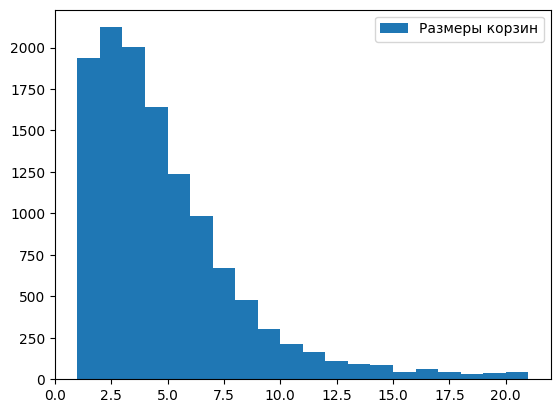

In [ ]:
# Отобразим гистограмму размеров корзин
plt.hist([len(c) for c in carts], 20, [1, 21],label="Размеры корзин")
plt.legend()
plt.show()

In [ ]:
labelEncoder = LabelEncoder()  # Создаем объект LabelEncoder
labelEncoder.fit(allPositions) # Обрабатываем все имеющиеся позиции товаров
maxPositionsCount = max(labelEncoder.transform(allPositions))+1 # Посчитаем количество уникальных товаров
cartsIndexes = [labelEncoder.transform(c) for c in carts]       # Создаем список индексов для каждой корзины

In [ ]:
# Количество уникальных товаров
maxPositionsCount

np.int64(6583)

In [ ]:
n = 3                  # Укажем номер корзины
print(carts[n])        # Отобразим содержимое этой корзины
print(cartsIndexes[n]) # Отобразим соответствующие индексы

['восстанавливающий эликсир luxeoil 100мл', 'маска для восстановления кератина luxeoil 400мл', 'шампунь для защиты кератина luxeoil 1000мл']
[3310 4498 6255]


In [ ]:
'''
  Функция преобразования вектора по приницпу bag of words
    Входные параметры:
      - trainVector - исходный вектор индексов слов
      - wordsCount - установленная длина вектора
    Функция возращает:
      - сформированный вектор из 0 и 1
'''
def changeXTo01(trainVector, wordsCount):
  out = np.zeros(wordsCount)                   # Создаем вектор из нулей длиной wordsCount
  for x in trainVector:                        # Пробегаем по всем индексам в trainVector
    out[x] = 1                                 # Изменяем на 1 значение out в позиции текущего индекса
  return out                                   # Возвращаем сформированный вектор


'''
  Функция преобразования выборки (обучающей или проверочной) по принципу Bag of words
    Входные параметры:
      - trainSet - выборка
      - wordsCount - установленная длина вектора
    Функция возращает:
      - сформированная выборка из 0 и 1
'''
def changeSetTo01(trainSet, wordsCount):
  out = []                                     # Создаем пустой список
  for x in trainSet:                           # Пробегаем по всем элемента выборки
    out.append(changeXTo01(x, wordsCount))     # Получаем вектор Bag of words для текущего элемента
  return np.array(out)                         # Возрващаем сформированную выборку

In [ ]:
carts01 = changeSetTo01(cartsIndexes, maxPositionsCount) # Создаем выборку по принципу bag of words

In [ ]:
n = 3                  # Указываем номер корзины
print(carts[n])        # Выводим содержимое корзины
print(cartsIndexes[n]) # Выводим список соответствующих индексов
print(carts01[n])      # Выводим соответсвующий список bag of words

['восстанавливающий эликсир luxeoil 100мл', 'маска для восстановления кератина luxeoil 400мл', 'шампунь для защиты кератина luxeoil 1000мл']
[3310 4498 6255]
[0. 0. 0. ... 0. 0. 0.]


## Кластеризация

In [ ]:
cur_time = time.time()
clustersCount = 100           # Указываем количество кластеров
kmean = KMeans(clustersCount) # Создаем объект KMeans
kmean.fit(carts01)            # Производим кластеризацию набора carts01
labels = kmean.labels_        # Сохраняем метки в переменную labels
npCarts = np.array(carts, dtype="object")     # Преобразуем список корзин в numpy
print('Время обработки: ', round(time.time() - cur_time,2),'c')

Время обработки:  42.86 c


In [ ]:
print(carts[0])
print(len(carts))
print(len(npCarts))

['contura hs61машинка для стрижки волос', 'holika holika универсальный гель 99% алоэ вера 250мл', 'kapous бальзам-уход для придания объема volume up 350мл', 'kapous шампунь для придания объема volume up 350мл', 'xpert hs71машинка для стрижки волос', 'лп тна саваж панаш 250мл', 'перчатки 50 пар винил размер s черные']
12704
12704


In [ ]:
def getCluster(x):
  clasterSize = x.shape[0]                           # Берем размер кластера
  sumX = np.sum(x, axis=0)                           # Считаем сумму кластера по позициям
  sumX /= clasterSize                                # Смотрим, насколько часто конкретная позиция появляется в данном кластере

  positions = []                                     # Создаем пустой список позиций
  positionValues = []                                # Создаем пустой список значений

  for i in range(sumX.shape[0]):                     # Пробегаем по всем имеющимся примерам товаров
    if (sumX[i] > 0):                                # Если товар присутствует в данном кластере
      position = labelEncoder.inverse_transform([i]) # Получаем обратный энкодер
      positions.append(position)                     # Добавляем позицию в список позиций
      positionValues.append(sumX[i])                 # В списк значений добавляем количество данной позиции в текущем кластере

  return positions, positionValues                   # Возвращаем список позиций кластера и количество каждой позиции

In [ ]:
clusterSize = [sum(labels==i) for i in range(0, clustersCount)] # Создадим список размеров каждого кластера

In [ ]:
print(len(clusterSize))
clusterSize[:10]

100


[np.int64(19),
 np.int64(24),
 np.int64(1),
 np.int64(66),
 np.int64(1),
 np.int64(137),
 np.int64(8004),
 np.int64(1),
 np.int64(101),
 np.int64(82)]

In [ ]:
for clusterNumber in range(len(clusterSize)):                # Пробегаем по всем кластерам
  if (clusterSize[clusterNumber] > 5):                       # Если размер кластера больше 5
    pos, posVal = getCluster(carts01[labels==clusterNumber]) # Получаем позиции и их количество в текущем кластере
    print("Покупок:", clusterSize[clusterNumber])            # Выводим размер текущего кластера
    print("Позиций:", len(pos))                              # Выводим общее число позиций в текущем кластере
    pos = np.array(pos)                                      # Преобразуем в numpy
    posVal = np.array(posVal)                                # Преобразуем в numpy
    indexes = posVal > 0.6                                   # Берем индексы тех позиций, доля которых составляет больше 20%
    indexedPos = pos[indexes]                                # Выбираем эти позиции из pos
    indexedPosVal = posVal[indexes]                          # Выбираем доли этих позиций

    # Отображаем долю позиции и название самой позиции
    for i in range(len(indexedPos)):
      print(round(100*indexedPosVal[i]), "% ", indexedPos[i], sep="")

    print()
    print()

Покупок: 19
Позиций: 328
63% ['ollin color 5/0 светлый шатен 60мл перманентная крем-краска д/волос']
63% ['ollin color 8/21 светло-русый фиолетово-пепельный 60мл перманентная крем-краска д/волос']
63% ['ollin color 9/21 блондин фиолетово-пепельный 60мл перманентная крем-краска д/волос']


Покупок: 24
Позиций: 165
75% ['энзимный пилинг papaya enzyme peel 150мл']


Покупок: 66
Позиций: 191
100% ['окислитель welloxon perfect 20v 6 0% 60мл']


Покупок: 137
Позиций: 532
100% ['скраб ягодная роскошь омолаживающий likato 250мл']


Покупок: 8004
Позиций: 5455


Покупок: 101
Позиций: 581
99% ['деликатный шампунь для окрашенных волос otium color life 1000мл']


Покупок: 82
Позиций: 273
100% ['шампунь глубокой очистки estel princess essex 1000мл']


Покупок: 196
Позиций: 596
70% ['кератиновая вода для волос estel keratin 100мл']
98% ['кератиновая маска для волос estel keratin 250мл']
96% ['кератиновый шампунь для волос estel keratin 250мл']


Покупок: 191
Позиций: 557
71% ['оксигент для волос 6% 

## 2. Выведите две гистограммы
 - Распределения размеров классов - сколько корзин
 - Распределение количества уникальных позиций в классе

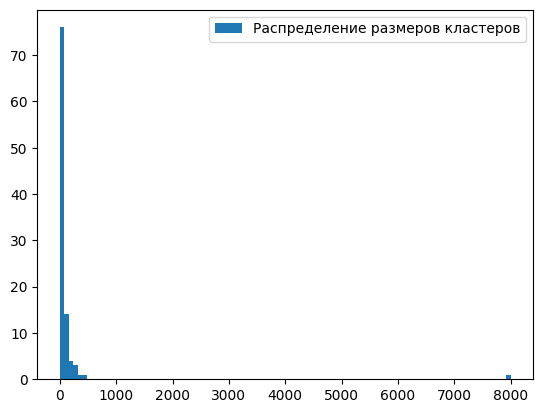

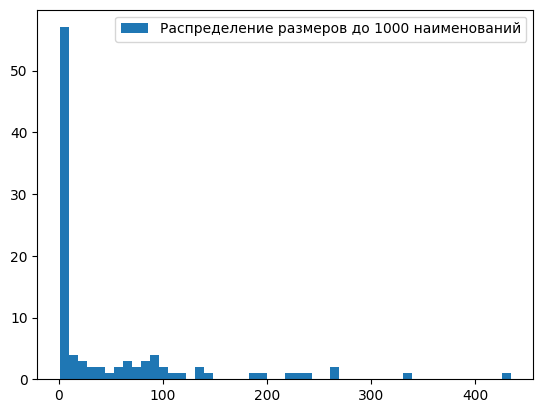

In [ ]:
plt.hist(clusterSize, 100, label="Распределение размеров кластеров")
plt.legend()
plt.show()

npClusterSize=np.array(clusterSize)
plt.hist(npClusterSize[npClusterSize<1000], 50, label="Распределение размеров до 1000 наименований")
plt.legend()
plt.show()


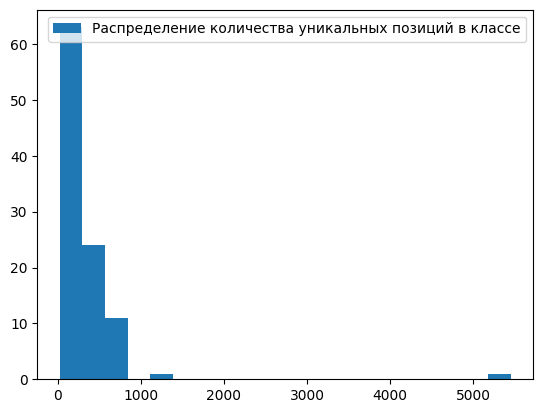

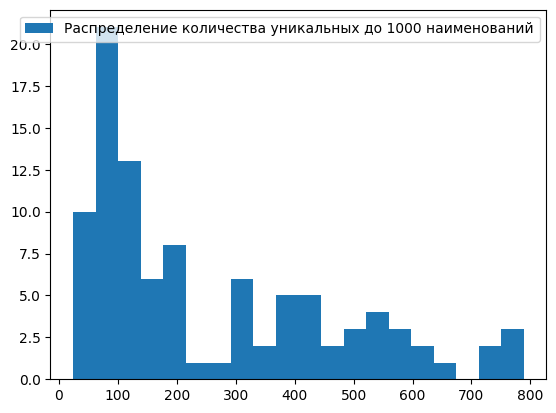

In [ ]:
numPosVal=[]
for clusterNumber in range(clustersCount):
  pos, posVal = getCluster(carts01[labels==clusterNumber]) # Получаем позиции и их количество в текущем кластере
  uniquePos=np.unique(pos) # Получаем только уникальные позиции в классе
  numPosVal.append(len(uniquePos))

plt.hist(numPosVal, 20, label="Распределение количества уникальных позиций в классе")
plt.legend()
plt.show()

npNumPosVal=np.array(numPosVal)
plt.hist(npNumPosVal[npNumPosVal<1000], 20, label="Распределение количества уникальных до 1000 наименований")
plt.legend()
plt.show()

# 3. Напишите продвинутую функцию визуализации одного выбранного класса
 - Размер класса
 - Количество уникальных позиций
 - Позиции, которые есть минимум в 20% корзин
 - Уникальные слова в описаниях позиций, которые встречаются минимум в 20% позиций, для отслеживания монобрендовых и монотоварных закупок.


In [ ]:
for clusterNumber in range(len(clusterSize)): # Пробегаем по всем кластерам
  if (clusterSize[clusterNumber] > 5):        # Если размер кластера больше 5
    print("Класс ",clusterNumber,"-"*20)
    print("Размер класса:", clusterSize[clusterNumber])

    # Получим количество уникальных позиций
    pos, posVal = getCluster(carts01[labels==clusterNumber])
    uniquePos = len(np.unique(pos))
    print("Количество уникальных позиций:",uniquePos)

    print()

    # Получим список позиций, которые есть минимум в 20% корзин
    print("Позиции, которые есть минимум в 20% корзин:")
    pos = np.array(pos)
    posVal = np.array(posVal)

    # Индексы позиций
    indexes = posVal >= 0.2
    indexedPos = pos[indexes]
    indexedPosVal = posVal[indexes]

    # Отсортируем позиции по количеству вхождений
    positions=[]
    for i in range(len(indexedPos)):
      positions.append([indexedPosVal[i],indexedPos[i]])
    positions=sorted(positions,reverse=1)

    # Выведем позиции
    for p in positions:
      print(round(100*p[0]), "% ", p[1][0], sep="")

    print()

    # Получим список частых слов, которые есть минимум в 20% корзин
    print("Уникальные слова в описаниях позиций:")

    words=[]
    for p in pos:
      words+=p[0].split(" ")
    uniqueWords=np.unique(words)

    uniqueWordsVals=[]
    for w in uniqueWords:
      wordVal=0
      for p in pos:
        if (w in p[0]):
          wordVal+=1
      uniqueWordsVals.append(wordVal/len(pos))

    uniqueWords=np.array(uniqueWords)
    uniqueWordsVals=np.array(uniqueWordsVals)

    indexes = uniqueWordsVals >= 0.2
    indexedWords = uniqueWords[indexes]
    indexedWordVals = uniqueWordsVals[indexes]

    sortedWords=[]
    for i in range(len(indexedWords)):
      sortedWords.append([indexedWordVals[i],indexedWords[i]])
    sortedWords=sorted(sortedWords,reverse=1)

    for w in sortedWords:
      print(round(100*w[0]), "% ", w[1], sep="")

    print()
    print()

Класс  0 --------------------
Размер класса: 19
Количество уникальных позиций: 328

Позиции, которые есть минимум в 20% корзин:
63% ollin color 9/21 блондин фиолетово-пепельный 60мл перманентная крем-краска д/волос
63% ollin color 8/21 светло-русый фиолетово-пепельный 60мл перманентная крем-краска д/волос
63% ollin color 5/0 светлый шатен 60мл перманентная крем-краска д/волос
58% ollin color 8/1 светло-русый пепельный 60мл перманентная крем-краска д/волос
58% ollin color 10/22 светлый блондин фиолетовый 60мл перманентная крем-краска д/волос
53% ollin color 9/81 блондин жемчужно-пепельный 60мл перманентная крем-краска д/волос
53% ollin color 9/26 блондин розовый 60мл перманентная крем-краска д/волос
53% ollin color 6/71 темно-русый коричнево-пепельный 60мл перманентная крем-краска д/волос
53% ollin color 5/71 светлый шатен коричнево-пепельный 60мл перманентная крем-краска д/волос
53% ollin color 5/1 светлый шатен пепельный 60мл перманентная крем-краска д/волос
53% ollin color 3/0 темный